In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats

from datetime import date
from datetime import datetime
from datetime import timedelta
%matplotlib inline
from matplotlib import pyplot as plt
from collections import defaultdict

#### 1, 2, 3. Загрузка данных за май 2016 года, проведение фильтрации и агрегирование данных

Наилучшей производительности удалось достичь при одновременной загрузке, фильтрации и агрегировании данных.

Выполнено удаление поезок с:
- нулевой длительностью
- нулевым количеством пассажиров
- нулевым расстоянием поездки по счётчику
- координатами начала, не попадающими в прямоугольник Нью-Йорка

In [2]:
#Нью-Йорк вписан в прямоугольник от -74.25559 до -73.70001 градусов долготы (longitude)
# и от 40.49612 до 40.91553 широты (lattitude). 
#Географическая широта – длина дуги в градусах от экватора до заданной точки
#Географическая долгота – длина дуги экватора в градусах от начального меридиана
#(0 градусов) до меридиана заданной точки
coord_NY = ((-74.25559, 40.49612), (-73.70001,  40.91553))

# Загружать будем только интересующие нас поля
traintypes = {'trip_distance': 'float32',
              'tpep_pickup_datetime': 'str', 
              'tpep_dropoff_datetime':'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'passenger_count': 'uint8'
             }

cols = list(traintypes.keys())
# размер чанка подобран для моего ПК, так чтобы не было свопа при выполнении кода.
# Своп очень сильно увеличивает время выполнения.
chunksize = 400_000

In [3]:
# Подготовим решетку координат для агрегирования
dfGrid = pd.read_csv('regions.csv', sep=';')
bins = [np.append(np.unique(dfGrid.west),  [dfGrid.east.max()]), 
        np.append(np.unique(dfGrid.south), [dfGrid.north.max()])
       ]

In [4]:
%%time
d_count = defaultdict(lambda:np.zeros([50, 50]))
nn = 0
for df in pd.read_csv('yellow_tripdata_2016-05.csv', 
                      usecols=cols, dtype=traintypes, chunksize=chunksize):
    nn+=1 
    for f in ['tpep_pickup_datetime', 'tpep_dropoff_datetime']:
        df[f] = df[f].str.slice(0, 19)
        df[f] = pd.to_datetime(df[f], utc=True, format='%Y-%m-%d %H:%M:%S')
#     Фильтруем считанные данные
    df.drop(df[
        (df.tpep_pickup_datetime >= df.tpep_dropoff_datetime)  |
        (df.passenger_count <= 0)   | 
        (df.trip_distance <= 0.) |
        (df.pickup_longitude < coord_NY[0][0]) |
        (df.pickup_longitude > coord_NY[1][0]) |
        (df.pickup_latitude < coord_NY[0][1]) |
        (df.pickup_latitude > coord_NY[1][1])
    ].index, inplace = True)
    
#     Индикатор, что бы не было скучно сидеть и ждать
    print('{:3d}'.format(nn), end='')
    
#   Агрегирование считанного фрагментра данных по часам и областям.
#   В результате агрегированные данные в словере d_count
    for dh, dtmp in  df[['pickup_longitude', 'pickup_latitude']].groupby(
            df.tpep_pickup_datetime.dt.floor('H')):
            
        H2, xedges2, yedges2, binnumber2 = stats.binned_statistic_2d(
            dtmp['pickup_longitude'].values, dtmp['pickup_latitude'].values, 
            None, bins = bins, statistic='count' )    
        d_count[dh] += H2
        del H2
        del xedges2
        del yedges2
        del binnumber2 
        del dtmp

print()         

  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
Wall time: 1min 7s


In [5]:
%%time
# Преобразуем агрегированные данные из структуры словаря в таблицу.
nregions = 2500
lcount, ldate = [], []
lreg = list(np.arange(1, nregions+1)) * len(d_count.keys())
for k in d_count.keys():
    lcount += list(d_count[k].ravel())
    ldate += ([k]*nregions)

df =  pd.DataFrame({'datetime': ldate, 'region': lreg, 'count':lcount} ) 
del lreg; del lcount; del ldate 

Wall time: 1.8 s


Проверка, что идентификаторы, которые присваиваете ячейкам, соответствуют приложенному выше файлу.

In [6]:
# Для проверки создаем набор данных, в которых точки несколько сдвинуты 
# вверх и вправо (но меньше чем на шаг клетки) при этом количество точек
# равно номеру ячейки (номер региона)
# Цель в том, что при правильном подсчете и преобразовании получим данные
# в которых номер региона будет совпадать с количеством точек в нем.

aX, aY = np.array([]), np.array([])
for index, row in dfGrid.iterrows():
    aX = np.append(aX, np.full( int(row['region']), row['west'] + 0.0004))
    aY = np.append(aY, np.full( int(row['region']), row['south'] + 0.0004))

# Набор данных создан. Теперь проведем его "разбор".
H2, xedges2, yedges2, binnumber2 = stats.binned_statistic_2d(
    aX, aY, 
    None, bins = bins, statistic='count' )    
# И проверим. 
test_num = True
for i, v in enumerate(H2.reshape([2500, 1])):
    if int(i+1) != int(v[0]):
        print(i, v[0])
        test_num=False

print('Результат проверки: {}'.format('OK' if test_num else 'ОШИБКА' ))

Результат проверки: OK


#### 4. Выведите первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок.

In [7]:
df.sort_values(by=['datetime', 'region']).head()

,datetime,region,count
0,2016-05-01 00:00:00+00:00,1,0.0
1,2016-05-01 00:00:00+00:00,2,0.0
2,2016-05-01 00:00:00+00:00,3,0.0
3,2016-05-01 00:00:00+00:00,4,0.0
4,2016-05-01 00:00:00+00:00,5,0.0


In [8]:
# Более интересна информация о первых регионах с поездками
df[df['count'] > 0].sort_values(by=['datetime', 'region']).head()

,datetime,region,count
1014,2016-05-01 00:00:00+00:00,1015,1.0
1016,2016-05-01 00:00:00+00:00,1017,1.0
1028,2016-05-01 00:00:00+00:00,1029,3.0
1029,2016-05-01 00:00:00+00:00,1030,1.0
1032,2016-05-01 00:00:00+00:00,1033,4.0


#### 5. Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.

In [9]:
# Данные о координатах Empire State Building
# Empire State Building, 350, 5th Avenue, Korea Town, Midtown South, 
# Manhattan Community Board 5, Manhattan, New York County, NYC, New York, 10018, USA
# (40.7484284, -73.9856546198733)
def region_number( coord, bins):
    X = np.searchsorted(bins[0], coord[1], side='left')
    Y = np.searchsorted(bins[1], coord[0], side='left')
    return (X-1) * 50 + Y

esb_region = region_number((40.7484284, -73.9856546198733), bins)
print("Регион Empire State Building: {}".format(esb_region))

Регион Empire State Building: 1231


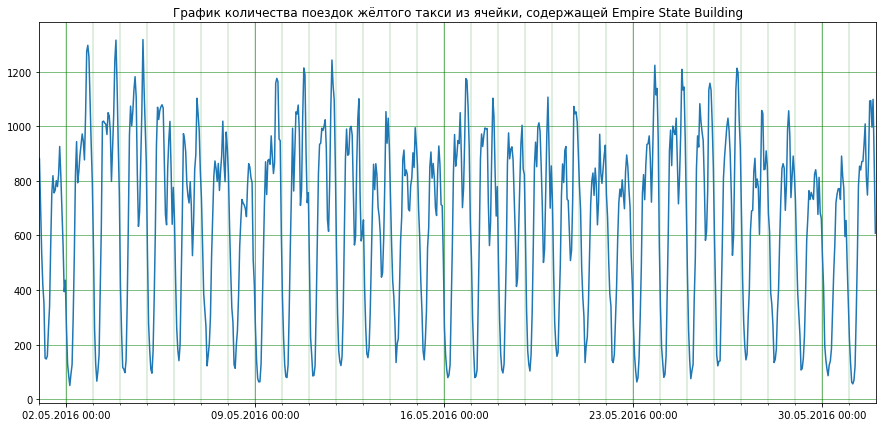

In [10]:
# 01.05.2016 - воскресенье
# сетка построена так, чтобы основные линии были с понедельника и по понедельникам
# а вспомогательные линии - в начале суток.
fig, ax = plt.subplots(figsize=(15, 7))

ser = df[df.region==esb_region].sort_values(by=['datetime'])[["datetime", 'count']]
max_num = len(ser.datetime.unique())
labelrange = np.arange(24 * ((7 - ser.datetime.min().weekday()) % 7), max_num, 24*7)
ax.plot(ser['count'].values)

ax.set_xticks(labelrange)
ax.set_xticklabels([ser.iloc[i].datetime.strftime("%d.%m.%Y %H:%M") for i in labelrange])
ax.set_xticks(np.arange(0, max_num, 24), minor=True)
plt.xlim(0, max_num)

plt.grid(b=True, which='major', color='g', lw=0.5) 
plt.grid(b=True, which='minor', color='g', lw=0.25) 
plt.title('График количества поездок жёлтого такси из ячейки, содержащей Empire State Building')
plt.show()

#### 6. Посчитайте, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.

In [11]:
# так как при аггрегировании ничего не сказано, что необходимо добавить в 
# таблицу нулевые значения ячеек для времени, которого нет в сырых данных,
# то для этого задания сначала проверим, не было ли "дыр" в сырых данных.
# Всего в мае 31*24 часов. Столько же должно быть уникальных дат в аггрегированных
# данных
len(df.datetime.unique()) == 31*24
# так как значения равны, то "дыр" нет.

True

In [12]:
ans_6 = df[df['count'] == 0.].count()
print("Для {:,d} пар час-ячейка в мае 2016 не было совершено ни одной поездки.".format(ans_6.region))

Для 1,718,238 пар час-ячейка в мае 2016 не было совершено ни одной поездки.
